In [ ]:
# Environment setup
import sys
from pathlib import Path

# Add src to path
workspace_root = Path.cwd()
while not (workspace_root / 'src').exists() and workspace_root != workspace_root.parent:
    workspace_root = workspace_root.parent

sys.path.insert(0, str(workspace_root / 'src'))

print(f"Project root: {workspace_root}")
print(f"Python version: {sys.version}")
print("✓ Environment configured")

In [11]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# PyTorch and forecasting
import torch
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Thesis pipeline utilities
from thesis_pipeline.io.parquet import read_parquet, write_parquet

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ All imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.backends.mps.is_available()}")

✓ All imports successful
PyTorch version: 2.9.0
CUDA available: False
MPS available: True


## 1. Load Daily Polarization Data

Load daily polarization time series for both Reddit and News.

In [12]:
# Paths
reddit_polarization_dir = workspace_root / 'data' / '04_polarization' / 'reddit'
news_polarization_dir = workspace_root / 'data' / '04_polarization' / 'news'
forecasting_dir = workspace_root / 'data' / '05_forecasting'
forecasting_dir.mkdir(parents=True, exist_ok=True)

print(f"Reddit polarization: {reddit_polarization_dir}")
print(f"News polarization: {news_polarization_dir}")
print(f"Forecasting output: {forecasting_dir}")

Reddit polarization: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/04_polarization/reddit
News polarization: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/04_polarization/news
Forecasting output: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/05_forecasting


In [13]:
# Load daily polarization data
reddit_daily_file = reddit_polarization_dir / 'polarization_daily.parquet'
news_daily_file = news_polarization_dir / 'polarization_daily.parquet'

data_sources = {}

if reddit_daily_file.exists():
    df_reddit = read_parquet(reddit_daily_file)
    df_reddit['source'] = 'reddit'
    
    # Ensure date column exists
    if 'date' in df_reddit.columns:
        df_reddit['date'] = pd.to_datetime(df_reddit['date'])
    else:
        raise ValueError("Reddit data missing 'date' column")
    
    data_sources['reddit'] = df_reddit
    print(f"✓ Loaded Reddit: {len(df_reddit):,} daily observations")
    print(f"  Topics: {df_reddit['topic'].nunique()}")
    print(f"  Date range: {df_reddit['date'].min()} to {df_reddit['date'].max()}")
else:
    print(f"⚠️  Reddit daily data not found")

if news_daily_file.exists():
    df_news = read_parquet(news_daily_file)
    df_news['source'] = 'news'
    
    # Ensure date column exists
    if 'date' in df_news.columns:
        df_news['date'] = pd.to_datetime(df_news['date'])
    else:
        raise ValueError("News data missing 'date' column")
    
    data_sources['news'] = df_news
    print(f"\n✓ Loaded News: {len(df_news):,} daily observations")
    print(f"  Topics: {df_news['topic'].nunique()}")
    print(f"  Date range: {df_news['date'].min()} to {df_news['date'].max()}")
else:
    print(f"\n⚠️  News daily data not found")

if not data_sources:
    raise FileNotFoundError(
        "No daily polarization data found. Please run polarization notebooks first."
    )

print(f"\n✓ Loaded {len(data_sources)} data source(s): {list(data_sources.keys())}")

✓ Loaded Reddit: 250 daily observations
  Topics: 5
  Date range: 2016-09-01 00:00:00 to 2016-10-31 00:00:00

✓ Loaded News: 54 daily observations
  Topics: 5
  Date range: 2016-09-11 00:00:00 to 2016-10-31 00:00:00

✓ Loaded 2 data source(s): ['reddit', 'news']


## 2. Prepare Data for TFT

TFT requires specific data format with time index and group identifiers.

In [14]:
# Configuration
MAX_ENCODER_LENGTH = 30  # Use 30 days of history (~1 month)
MAX_PREDICTION_LENGTH = 14  # Forecast 14 days ahead (~2 weeks)
BATCH_SIZE = 32
MAX_EPOCHS = 50

print(f"TFT Configuration:")
print(f"  Encoder length: {MAX_ENCODER_LENGTH} days")
print(f"  Prediction length: {MAX_PREDICTION_LENGTH} days")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max epochs: {MAX_EPOCHS}")

TFT Configuration:
  Encoder length: 30 days
  Prediction length: 14 days
  Batch size: 32
  Max epochs: 50


In [15]:
# Prepare data for TFT (separately for each source)
print("Preparing data for TFT...")

prepared_data = {}

for source_name, df_source in data_sources.items():
    print(f"\nProcessing {source_name.upper()}...")
    
    # Ensure datetime format
    df_source = df_source.copy()
    df_source['date'] = pd.to_datetime(df_source['date'])
    
    # Create unique group identifier (topic name)
    df_source['group'] = df_source['topic']
    
    # Sort by group and date
    df_source = df_source.sort_values(['group', 'date'])
    
    # Create time index (sequential integer per group)
    df_source['time_idx'] = df_source.groupby('group').cumcount()
    
    # Select features
    # Target: er_polarization
    # Additional features: bipolarity, balance, extremism, total_articles/total_comments
    feature_columns = [
        'group', 'time_idx', 'date',
        'er_polarization',  # Target variable
        'bipolarity', 'balance', 'extremism',  # Time-varying covariates
        'topic'  # Categorical static feature
    ]
    
    # Add total_articles or total_comments if available
    if 'total_articles' in df_source.columns:
        feature_columns.append('total_articles')
    elif 'total_comments' in df_source.columns:
        feature_columns.append('total_comments')
    
    # Keep only available columns
    feature_columns = [col for col in feature_columns if col in df_source.columns]
    df_tft = df_source[feature_columns].copy()
    
    # Remove groups with insufficient data
    min_length = MAX_ENCODER_LENGTH + MAX_PREDICTION_LENGTH
    group_sizes = df_tft.groupby('group').size()
    valid_groups = group_sizes[group_sizes >= min_length].index
    df_tft = df_tft[df_tft['group'].isin(valid_groups)]
    
    if len(df_tft) == 0:
        print(f"  ⚠️  No valid groups with sufficient data (need >= {min_length} observations)")
        continue
    
    print(f"  ✓ Prepared {len(df_tft):,} observations")
    print(f"    Groups: {df_tft['group'].nunique()}")
    print(f"    Features: {len(feature_columns)}")
    print(f"    Time range: {df_tft['time_idx'].min()} to {df_tft['time_idx'].max()}")
    print(f"    Removed {group_sizes[group_sizes < min_length].shape[0]} groups with < {min_length} observations")
    
    prepared_data[source_name] = df_tft

if not prepared_data:
    raise ValueError("No sources have sufficient data for TFT forecasting")

print(f"\n✓ Prepared {len(prepared_data)} source(s): {list(prepared_data.keys())}")

Preparing data for TFT...

Processing REDDIT...
  ✓ Prepared 244 observations
    Groups: 4
    Features: 9
    Time range: 0 to 60
    Removed 1 groups with < 44 observations

Processing NEWS...
  ⚠️  No valid groups with sufficient data (need >= 44 observations)

✓ Prepared 1 source(s): ['reddit']


In [16]:
# Train-validation split (for each source)
print("\nCreating train-validation splits...")

train_val_data = {}

for source_name, df_tft in prepared_data.items():
    # Use last MAX_PREDICTION_LENGTH time steps for validation
    max_time_idx = df_tft.groupby('group')['time_idx'].max()
    cutoff = max_time_idx - MAX_PREDICTION_LENGTH
    
    # Create validation flag
    df_tft = df_tft.copy()
    df_tft['is_validation'] = False
    for group, cutoff_time in cutoff.items():
        mask = (df_tft['group'] == group) & (df_tft['time_idx'] > cutoff_time)
        df_tft.loc[mask, 'is_validation'] = True
    
    train_df = df_tft[~df_tft['is_validation']].copy()
    val_df = df_tft[df_tft['is_validation']].copy()
    
    train_val_data[source_name] = {
        'train': train_df,
        'val': val_df,
        'full': df_tft
    }
    
    print(f"\n{source_name.upper()}:")
    print(f"  Training: {len(train_df):,} observations")
    print(f"  Validation: {len(val_df):,} observations")
    print(f"  Validation ratio: {len(val_df) / len(df_tft) * 100:.1f}%")

print(f"\n✓ Created splits for {len(train_val_data)} source(s)")


Creating train-validation splits...

REDDIT:
  Training: 188 observations
  Validation: 56 observations
  Validation ratio: 23.0%

✓ Created splits for 1 source(s)


## 3. Create TimeSeriesDataSet

Create PyTorch Forecasting dataset with proper configuration for each source separately.

In [17]:
# Create training dataset (for each source)
print("Creating TimeSeriesDataSets...")

datasets = {}

for source_name, data_dict in train_val_data.items():
    train_df = data_dict['train']
    df_full = data_dict['full']
    
    print(f"\n{source_name.upper()}:")
    
    # Determine static categoricals (only 'topic' now since we're separate by source)
    static_cats = ['topic']
    
    training = TimeSeriesDataSet(
        train_df,
        time_idx='time_idx',
        target='er_polarization',
        group_ids=['group'],
        max_encoder_length=MAX_ENCODER_LENGTH,
        max_prediction_length=MAX_PREDICTION_LENGTH,
        static_categoricals=static_cats,
        time_varying_known_reals=['time_idx'],
        time_varying_unknown_reals=[
            'er_polarization', 'bipolarity', 'balance', 'extremism'
        ],
        target_normalizer=GroupNormalizer(
            groups=['group'], transformation='softplus'
        ),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )
    
    print(f"  ✓ Training dataset created: {len(training)} samples")
    
    # Create validation dataset
    validation = TimeSeriesDataSet.from_dataset(
        training, df_full, predict=True, stop_randomization=True
    )
    
    print(f"  ✓ Validation dataset created: {len(validation)} samples")
    
    datasets[source_name] = {
        'training': training,
        'validation': validation
    }

print(f"\n✓ Created datasets for {len(datasets)} source(s)")

Creating TimeSeriesDataSets...

REDDIT:
  ✓ Training dataset created: 16 samples
  ✓ Validation dataset created: 4 samples

✓ Created datasets for 1 source(s)


In [18]:
# Create dataloaders (for each source)
dataloaders = {}

for source_name, dataset_dict in datasets.items():
    train_dataloader = dataset_dict['training'].to_dataloader(
        train=True, batch_size=BATCH_SIZE, num_workers=0
    )
    
    val_dataloader = dataset_dict['validation'].to_dataloader(
        train=False, batch_size=BATCH_SIZE, num_workers=0
    )
    
    dataloaders[source_name] = {
        'train': train_dataloader,
        'val': val_dataloader
    }
    
    print(f"{source_name.upper()}:")
    print(f"  Training batches: {len(train_dataloader)}")
    print(f"  Validation batches: {len(val_dataloader)}")

print(f"\n✓ Created dataloaders for {len(dataloaders)} source(s)")

REDDIT:
  Training batches: 1
  Validation batches: 1

✓ Created dataloaders for 1 source(s)


## 4. Train TFT Model

Train the Temporal Fusion Transformer (separately for each source).

In [20]:
# Configure and train TFT models (one per source)
print("Configuring TFT models...")

trained_models = {}
train_durations = {}

for source_name, dataset_dict in datasets.items():
    print(f"\n{'='*60}")
    print(f"TRAINING MODEL FOR {source_name.upper()}")
    print(f"{'='*60}")
    
    training_dataset = dataset_dict['training']
    train_dataloader = dataloaders[source_name]['train']
    val_dataloader = dataloaders[source_name]['val']
    
    # Create TFT model
    tft = TemporalFusionTransformer.from_dataset(
        training_dataset,
        learning_rate=0.03,
        hidden_size=32,  # Smaller for limited data
        attention_head_size=2,
        dropout=0.1,
        hidden_continuous_size=16,
        output_size=7,  # Quantile outputs
        loss=QuantileLoss(),
        log_interval=10,
        reduce_on_plateau_patience=4,
    )
    
    print(f"\n✓ TFT model configured")
    print(f"  Parameters: {sum(p.numel() for p in tft.parameters()):,}")
    
    # Configure trainer
    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        min_delta=1e-4,
        patience=10,
        verbose=False,
        mode='min'
    )
    
    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    
    trainer = pl.Trainer(
        max_epochs=MAX_EPOCHS,
        accelerator='auto',
        gradient_clip_val=0.1,
        callbacks=[early_stop_callback, lr_monitor],
        enable_progress_bar=True,
        enable_model_summary=False,
    )
    
    print(f"\n✓ Trainer configured")
    print(f"  Max epochs: {MAX_EPOCHS}")
    print(f"  Early stopping patience: 10")
    
    # Train model
    print(f"\nTraining {source_name.upper()} model...")
    train_start = datetime.now()
    
    trainer.fit(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )
    
    train_end = datetime.now()
    train_duration = (train_end - train_start).total_seconds()
    train_durations[source_name] = train_duration
    
    print(f"\n✓ Training complete!")
    print(f"  Duration: {train_duration / 60:.1f} minutes")
    print(f"  Best validation loss: {trainer.callback_metrics.get('val_loss', 'N/A')}")
    
    # Get best model
    # Use the trained model directly since loading from checkpoint can have issues with custom classes
    best_tft = tft
    print(f"  ✓ Using trained model (skipping checkpoint loading due to PyTorch 2.6+ security restrictions)")
    
    trained_models[source_name] = {
        'model': best_tft,
        'trainer': trainer,
        'training_dataset': training_dataset
    }

print(f"\n{'='*60}")
print(f"✓ Trained {len(trained_models)} model(s)")
print(f"{'='*60}")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Configuring TFT models...

TRAINING MODEL FOR REDDIT

✓ TFT model configured
  Parameters: 75,043

✓ Trainer configured
  Max epochs: 50
  Early stopping patience: 10

Training REDDIT model...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.



✓ Training complete!
  Duration: 0.6 minutes
  Best validation loss: 0.013408705592155457
  ✓ Using trained model (skipping checkpoint loading due to PyTorch 2.6+ security restrictions)

✓ Trained 1 model(s)


In [21]:
# Training configuration is now handled in the model training cell above
print("Models trained successfully for all sources!")
print(f"\nTotal training times:")
for source, duration in train_durations.items():
    print(f"  {source}: {duration/60:.1f} minutes")

Models trained successfully for all sources!

Total training times:
  reddit: 0.6 minutes


In [22]:
# Model training is now complete (see cell above)
# All trained models are stored in the trained_models dictionary
print(f"✓ All models ready for predictions")
print(f"\nTrained sources: {list(trained_models.keys())}")

✓ All models ready for predictions

Trained sources: ['reddit']


## 5. Generate Predictions

Use trained model to generate forecasts.

In [44]:
# Generate predictions (for each source)
print("Generating predictions...")

all_predictions = {}

for source_name, model_dict in trained_models.items():
    best_tft = model_dict['model']
    val_dataloader = dataloaders[source_name]['val']
    
    print(f"\n{source_name.upper()}:")
    
    # Generate predictions on validation set
    predictions = best_tft.predict(
        val_dataloader, mode='prediction', return_x=True, return_y=True, return_index=True
    )
    
    print(f"  ✓ Generated predictions")
    print(f"    Shape: {predictions.output.shape}")
    
    all_predictions[source_name] = predictions

print(f"\n✓ Generated predictions for {len(all_predictions)} source(s)")

Generating predictions...

REDDIT:
  ✓ Generated predictions
    Shape: torch.Size([4, 14])

✓ Generated predictions for 1 source(s)


In [45]:
# Extract predictions and actuals (for each source)
print("Extracting predictions and actuals...")

extracted_results = {}

for source_name, predictions in all_predictions.items():
    print(f"\n{source_name.upper()}:")
    print(f"  Prediction output shape: {predictions.output.shape}")
    print(f"  Prediction output type: {type(predictions.output)}")
    print(f"  Prediction output dim: {predictions.output.dim()}")
    
    # Handle different output shapes
    # TFT can return:
    # - 3D [batch, timesteps, quantiles] when returning all quantiles
    # - 2D [batch, timesteps] when returning single quantile/median
    # - 2D [batch, quantiles] when returning single timestep with quantiles
    
    if predictions.output.dim() == 3:
        # Shape: [batch, timesteps, quantiles]
        # Use median (index 3 of 7 quantiles)
        pred_values = predictions.output[:, :, 3].cpu().numpy()
        print(f"  Extracted median quantile from 3D output")
    elif predictions.output.dim() == 2:
        # Need to determine if this is [batch, timesteps] or [batch, quantiles]
        second_dim = predictions.output.shape[1]
        if second_dim == MAX_PREDICTION_LENGTH:
            # This is [batch, timesteps] - point predictions already
            pred_values = predictions.output.cpu().numpy()
            print(f"  Using 2D output as [batch, timesteps] point predictions")
        elif second_dim == 7:  # output_size from model config
            # This is [batch, quantiles] - single timestep
            pred_values = predictions.output[:, 3].cpu().numpy()
            pred_values = pred_values.reshape(-1, 1)
            print(f"  Extracted median quantile from 2D [batch, quantiles] output")
        else:
            # Assume it's [batch, timesteps]
            pred_values = predictions.output.cpu().numpy()
            print(f"  Assuming 2D output is [batch, timesteps={second_dim}]")
    else:
        raise ValueError(f"Unexpected prediction output dimensions: {predictions.output.dim()}")
    
    # Extract actual values
    # predictions.y is a tuple where first element is the target
    if isinstance(predictions.y, (list, tuple)):
        actual_values = predictions.y[0].cpu().numpy()
    else:
        actual_values = predictions.y.cpu().numpy()
    
    indices = predictions.index
    
    extracted_results[source_name] = {
        'predictions': pred_values,
        'actuals': actual_values,
        'indices': indices
    }
    
    print(f"  Final predicted shape: {pred_values.shape}")
    print(f"  Final actual shape: {actual_values.shape}")
    print(f"  Number of forecasts: {len(pred_values)}")

print(f"\n✓ Extracted results for {len(extracted_results)} source(s)")

Extracting predictions and actuals...

REDDIT:
  Prediction output shape: torch.Size([4, 14])
  Prediction output type: <class 'torch.Tensor'>
  Prediction output dim: 2
  Using 2D output as [batch, timesteps] point predictions
  Final predicted shape: (4, 14)
  Final actual shape: (4, 14)
  Number of forecasts: 4

✓ Extracted results for 1 source(s)


## 6. Evaluate Performance

Calculate evaluation metrics for each group.

In [46]:
# Organize results by group (for each source)
all_results_by_group = {}

for source_name, result_dict in extracted_results.items():
    pred_values = result_dict['predictions']
    actual_values = result_dict['actuals']
    indices = result_dict['indices']
    
    print(f"\n{source_name.upper()}:")
    print(f"  Predictions shape: {pred_values.shape}")
    print(f"  Actuals shape: {actual_values.shape}")
    
    results_by_group = {}
    
    for i in range(len(pred_values)):
        group = indices['group'].iloc[i]
        
        if group not in results_by_group:
            results_by_group[group] = {
                'predictions': [],
                'actuals': []
            }
        
        # Handle different dimensions independently for preds and actuals
        pred_seq = pred_values[i]
        actual_seq = actual_values[i]
        
        # Convert predictions to list
        if pred_seq.ndim == 0:  # scalar
            pred_list = [float(pred_seq)]
        else:  # 1D array
            pred_list = pred_seq.tolist() if hasattr(pred_seq, 'tolist') else [float(pred_seq)]
        
        # Convert actuals to list
        if actual_seq.ndim == 0:  # scalar
            actual_list = [float(actual_seq)]
        else:  # 1D array
            actual_list = actual_seq.tolist() if hasattr(actual_seq, 'tolist') else [float(actual_seq)]
        
        # Debug: print shapes to understand mismatch
        print(f"  Group {group}: pred_list length={len(pred_list)}, actual_list length={len(actual_list)}")
        
        results_by_group[group]['predictions'].extend(pred_list)
        results_by_group[group]['actuals'].extend(actual_list)
    
    all_results_by_group[source_name] = results_by_group
    print(f"  Organized results for {len(results_by_group)} groups")

print(f"\n✓ Organized results for all sources")


REDDIT:
  Predictions shape: (4, 14)
  Actuals shape: (4, 14)
  Group climate_change: pred_list length=14, actual_list length=14
  Group donald_trump: pred_list length=14, actual_list length=14
  Group gun_control: pred_list length=14, actual_list length=14
  Group immigration: pred_list length=14, actual_list length=14
  Organized results for 4 groups

✓ Organized results for all sources


In [47]:
# Calculate metrics for each group (for each source)
forecasting_results = []

print("=" * 80)
print("TFT FORECASTING PERFORMANCE")
print("=" * 80)

for source_name, results_by_group in all_results_by_group.items():
    print(f"\n{'-'*80}")
    print(f"{source_name.upper()}")
    print(f"{'-'*80}")
    
    for group, data in results_by_group.items():
        preds = np.array(data['predictions'])
        actuals = np.array(data['actuals'])
        
        # Remove any NaN values
        mask = ~(np.isnan(preds) | np.isnan(actuals))
        preds = preds[mask]
        actuals = actuals[mask]
        
        if len(preds) == 0:
            continue
        
        # Calculate metrics
        mae = mean_absolute_error(actuals, preds)
        rmse = np.sqrt(mean_squared_error(actuals, preds))
        mape = mean_absolute_percentage_error(actuals, preds) * 100
        
        # Topic is the group name (since we're processing each source separately)
        topic = group
        
        print(f"\n{topic}:")
        print(f"  Samples: {len(preds)}")
        print(f"  MAE: {mae:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAPE: {mape:.2f}%")
        
        result = {
            'source': source_name,
            'topic': topic,
            'group': group,
            'num_predictions': len(preds),
            'mae': float(mae),
            'rmse': float(rmse),
            'mape': float(mape),
            'predictions': preds.tolist(),
            'actuals': actuals.tolist()
        }
        
        forecasting_results.append(result)

print(f"\n{'='*80}")
print(f"✓ Evaluated {len(forecasting_results)} groups across all sources")
print(f"{'='*80}")

TFT FORECASTING PERFORMANCE

--------------------------------------------------------------------------------
REDDIT
--------------------------------------------------------------------------------

climate_change:
  Samples: 14
  MAE: 0.0535
  RMSE: 0.0618
  MAPE: 1522466681183131.75%

donald_trump:
  Samples: 14
  MAE: 0.0049
  RMSE: 0.0058
  MAPE: 2.89%

gun_control:
  Samples: 14
  MAE: 0.0202
  RMSE: 0.0237
  MAPE: 9.12%

immigration:
  Samples: 14
  MAE: 0.0136
  RMSE: 0.0154
  MAPE: 5.70%

✓ Evaluated 4 groups across all sources


## 7. Performance Summary

Summarize TFT forecasting performance.

In [48]:
# Create results dataframe
results_df = pd.DataFrame(forecasting_results)

print("=" * 80)
print("TFT FORECASTING PERFORMANCE SUMMARY")
print("=" * 80)

print(f"\nOverall statistics:")
print(results_df[['mae', 'rmse', 'mape']].describe())

print(f"\n\nPerformance by source:")
for source in results_df['source'].unique():
    source_data = results_df[results_df['source'] == source]
    print(f"\n{source.upper()}:")
    print(f"  Mean MAE: {source_data['mae'].mean():.4f}")
    print(f"  Mean RMSE: {source_data['rmse'].mean():.4f}")
    print(f"  Mean MAPE: {source_data['mape'].mean():.2f}%")

print(f"\n\nBest performing topics (by MAE):")
print(results_df.nsmallest(5, 'mae')[['source', 'topic', 'mae', 'rmse', 'mape']])

print(f"\n\nWorst performing topics (by MAE):")
print(results_df.nlargest(5, 'mae')[['source', 'topic', 'mae', 'rmse', 'mape']])

TFT FORECASTING PERFORMANCE SUMMARY

Overall statistics:
            mae      rmse          mape
count  4.000000  4.000000  4.000000e+00
mean   0.023067  0.026688  3.806167e+14
std    0.021254  0.024498  7.612333e+14
min    0.004910  0.005836  2.893685e+00
25%    0.011462  0.013045  4.998927e+00
50%    0.016910  0.019576  7.408554e+00
75%    0.028515  0.033219  3.806167e+14
max    0.053537  0.061765  1.522467e+15


Performance by source:

REDDIT:
  Mean MAE: 0.0231
  Mean RMSE: 0.0267
  Mean MAPE: 380616670295787.38%


Best performing topics (by MAE):
   source           topic       mae      rmse          mape
1  reddit    donald_trump  0.004910  0.005836  2.893685e+00
3  reddit     immigration  0.013646  0.015448  5.700674e+00
2  reddit     gun_control  0.020174  0.023704  9.116434e+00
0  reddit  climate_change  0.053537  0.061765  1.522467e+15


Worst performing topics (by MAE):
   source           topic       mae      rmse          mape
0  reddit  climate_change  0.053537  0.061765 

## 8. Visualize Forecasts

Plot predictions vs actuals for each group.

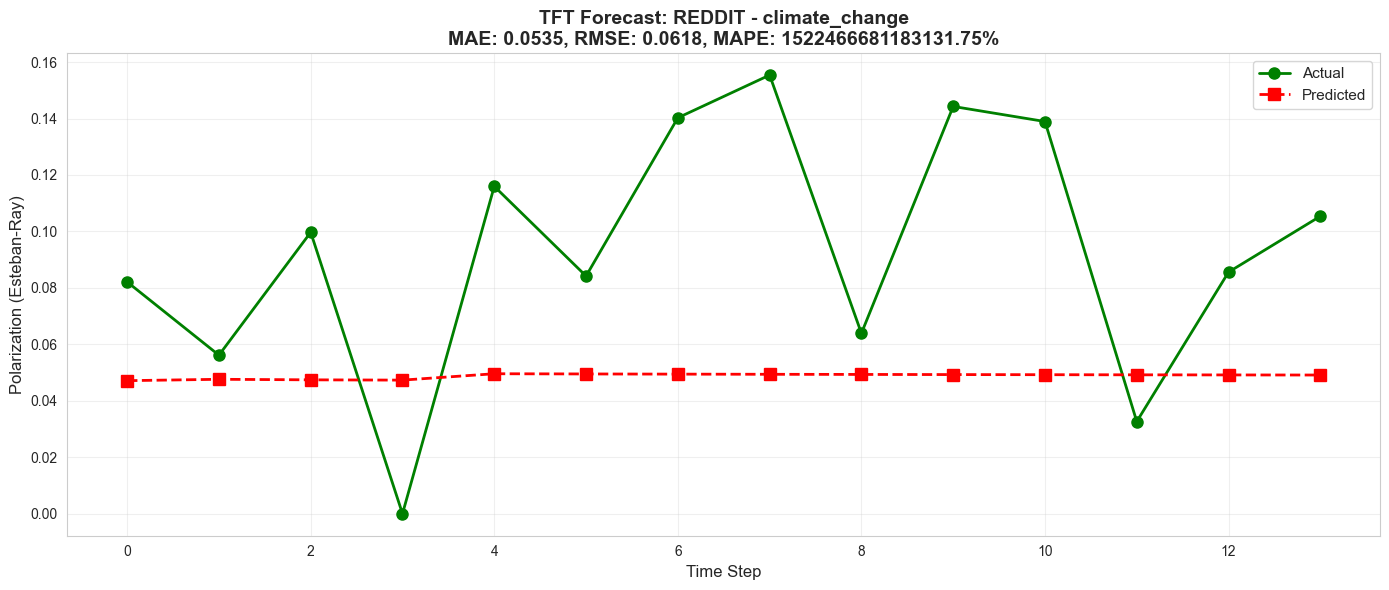

✓ Saved: tft_forecast_reddit_climate_change.png


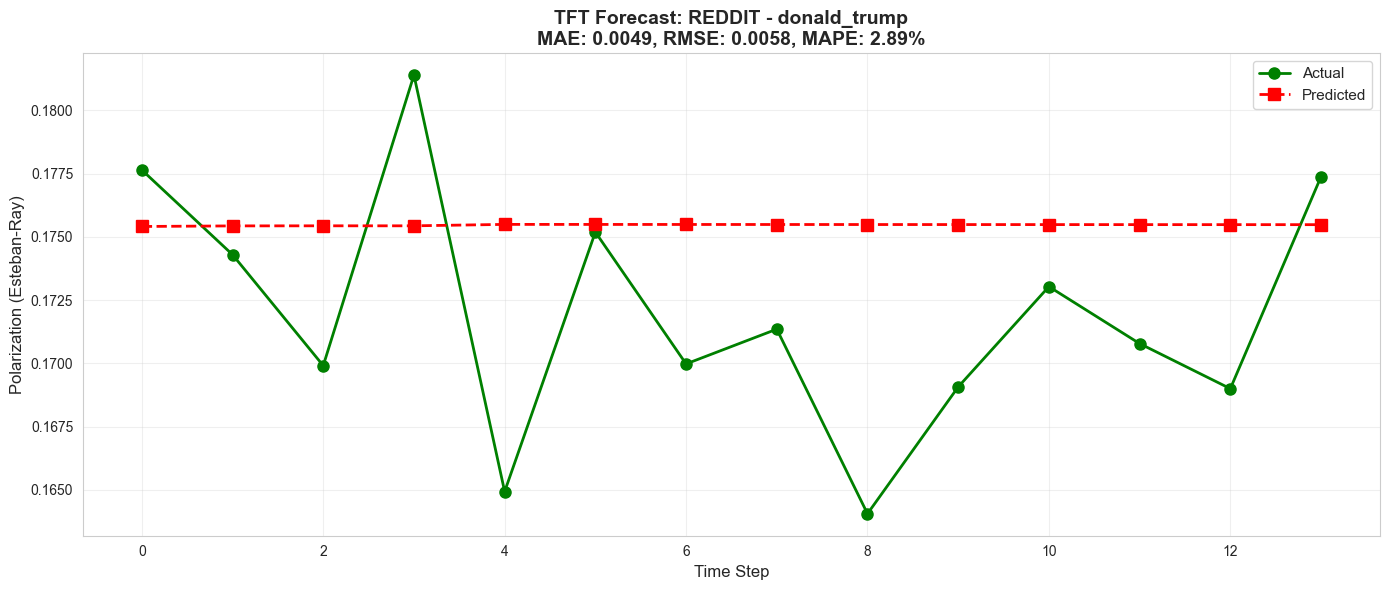

✓ Saved: tft_forecast_reddit_donald_trump.png


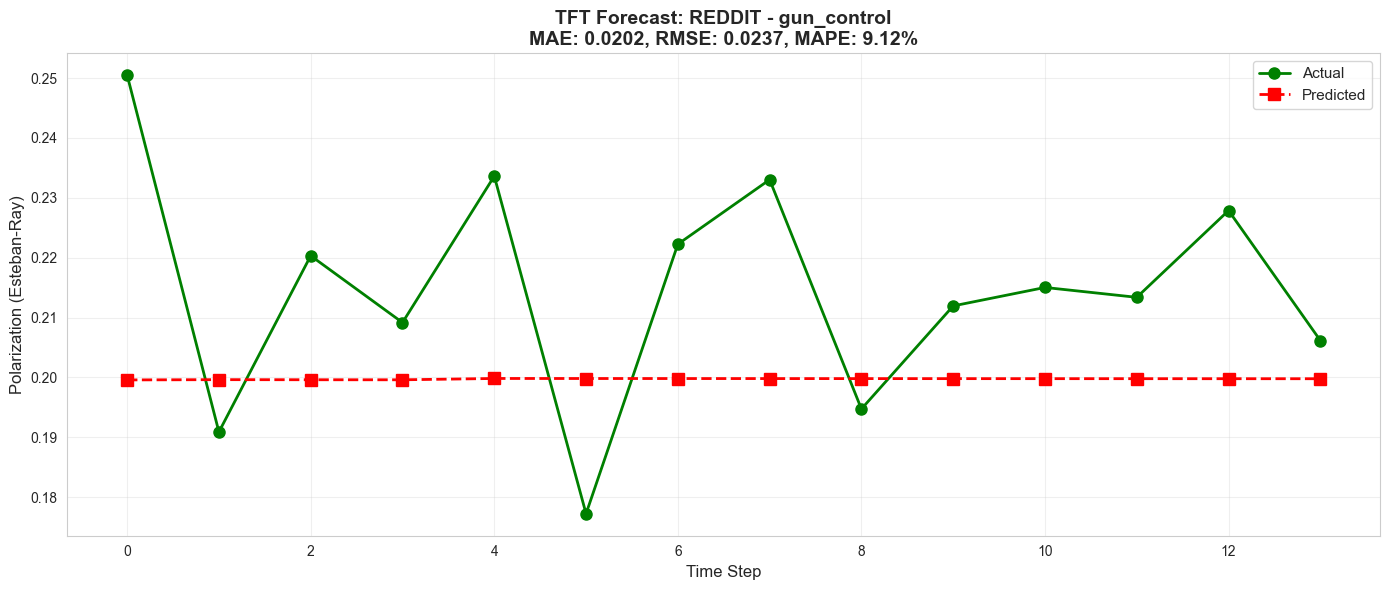

✓ Saved: tft_forecast_reddit_gun_control.png


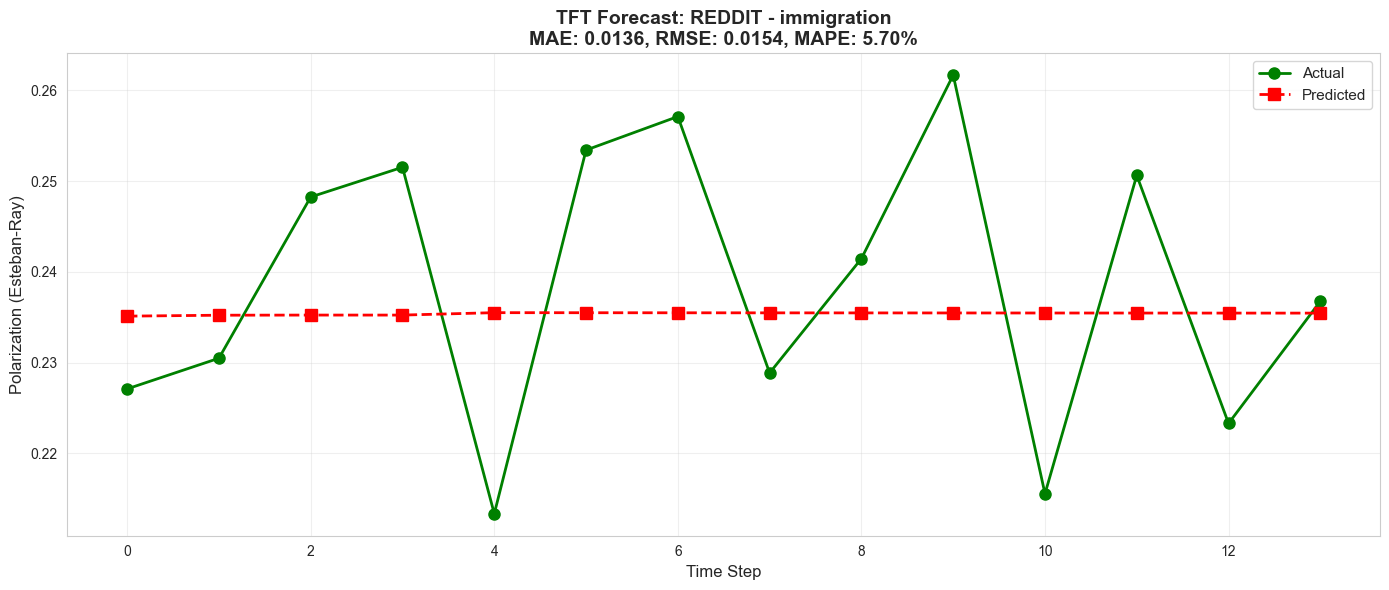

✓ Saved: tft_forecast_reddit_immigration.png

✓ Generated 4 forecast plots


In [49]:
# Plot forecasts
for result in forecasting_results:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    actuals = result['actuals']
    predictions = result['predictions']
    x = np.arange(len(actuals))
    
    ax.plot(x, actuals, 'o-', label='Actual', linewidth=2, markersize=8, color='green')
    ax.plot(x, predictions, 's--', label='Predicted', linewidth=2, markersize=8, color='red')
    
    ax.set_title(
        f"TFT Forecast: {result['source'].upper()} - {result['topic']}\n"
        f"MAE: {result['mae']:.4f}, RMSE: {result['rmse']:.4f}, MAPE: {result['mape']:.2f}%",
        fontsize=14,
        fontweight='bold'
    )
    ax.set_xlabel('Time Step', fontsize=12)
    ax.set_ylabel('Polarization (Esteban-Ray)', fontsize=12)
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    filename = f"tft_forecast_{result['source']}_{result['topic']}.png"
    plt.savefig(forecasting_dir / filename, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Saved: {filename}")

print(f"\n✓ Generated {len(forecasting_results)} forecast plots")

## 9. Compare with ETS

Load ETS results and compare performance.

TFT vs ETS COMPARISON

Overall performance:

TFT:
  Mean MAE: 0.0231
  Mean RMSE: 0.0267
  Mean MAPE: 380616670295787.38%

ETS:
  Mean MAE: 0.0581
  Mean RMSE: 0.0676
  Mean MAPE: 838227023916425.50%

Improvement:
  MAE: +60.3%
  RMSE: +60.5%


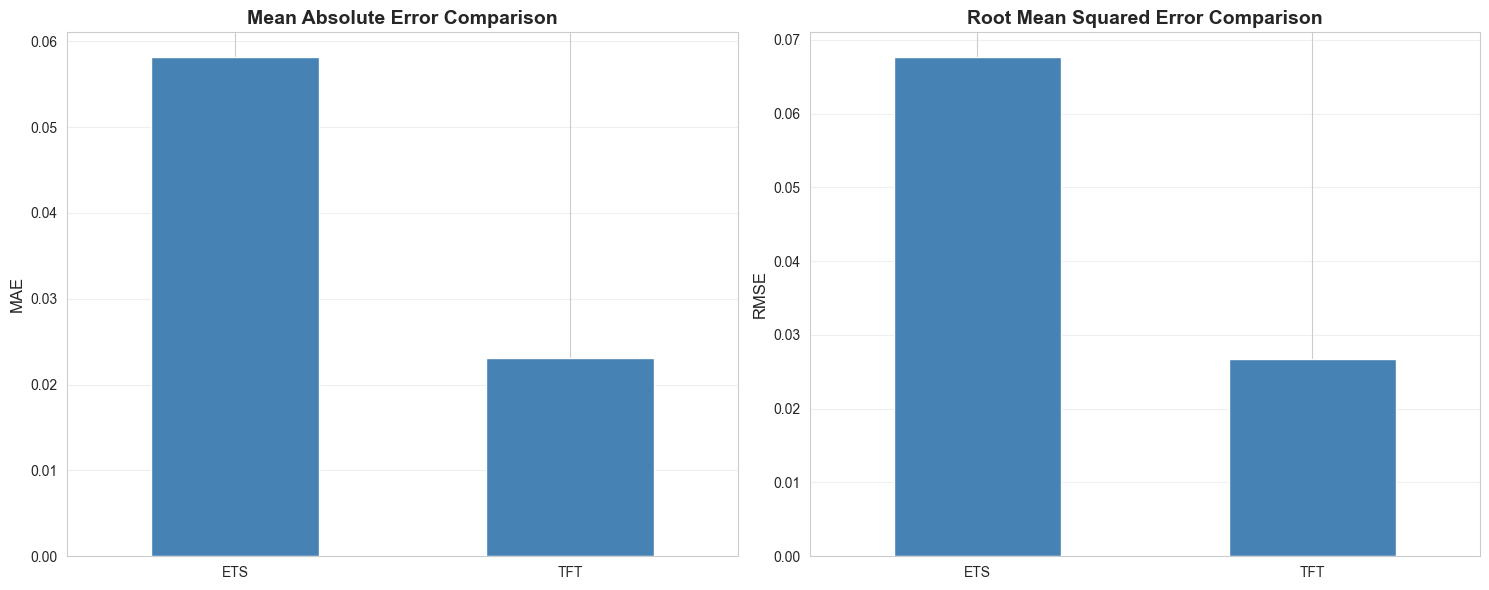


✓ Saved: tft_vs_ets_comparison.png


In [50]:
# Load ETS results for comparison
ets_results_file = forecasting_dir / '30_ets_results.parquet'

if ets_results_file.exists():
    ets_df = read_parquet(ets_results_file)
    
    print("=" * 80)
    print("TFT vs ETS COMPARISON")
    print("=" * 80)
    
    print(f"\nOverall performance:")
    print(f"\nTFT:")
    print(f"  Mean MAE: {results_df['mae'].mean():.4f}")
    print(f"  Mean RMSE: {results_df['rmse'].mean():.4f}")
    print(f"  Mean MAPE: {results_df['mape'].mean():.2f}%")
    
    print(f"\nETS:")
    print(f"  Mean MAE: {ets_df['mae'].mean():.4f}")
    print(f"  Mean RMSE: {ets_df['rmse'].mean():.4f}")
    print(f"  Mean MAPE: {ets_df['mape'].mean():.2f}%")
    
    # Improvement
    mae_improvement = (ets_df['mae'].mean() - results_df['mae'].mean()) / ets_df['mae'].mean() * 100
    rmse_improvement = (ets_df['rmse'].mean() - results_df['rmse'].mean()) / ets_df['rmse'].mean() * 100
    
    print(f"\nImprovement:")
    print(f"  MAE: {mae_improvement:+.1f}%")
    print(f"  RMSE: {rmse_improvement:+.1f}%")
    
    # Visualize comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # MAE comparison
    ax = axes[0]
    comparison_data = pd.DataFrame({
        'ETS': [ets_df['mae'].mean()],
        'TFT': [results_df['mae'].mean()]
    })
    comparison_data.T.plot(kind='bar', ax=ax, legend=False, color=['steelblue', 'coral'])
    ax.set_title('Mean Absolute Error Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel('MAE', fontsize=12)
    ax.set_xticklabels(['ETS', 'TFT'], rotation=0)
    ax.grid(axis='y', alpha=0.3)
    
    # RMSE comparison
    ax = axes[1]
    comparison_data = pd.DataFrame({
        'ETS': [ets_df['rmse'].mean()],
        'TFT': [results_df['rmse'].mean()]
    })
    comparison_data.T.plot(kind='bar', ax=ax, legend=False, color=['steelblue', 'coral'])
    ax.set_title('Root Mean Squared Error Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel('RMSE', fontsize=12)
    ax.set_xticklabels(['ETS', 'TFT'], rotation=0)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(forecasting_dir / 'tft_vs_ets_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Saved: tft_vs_ets_comparison.png")
    
else:
    print("\n⚠️  ETS results not found, skipping comparison")

## 10. Save Results

Save TFT forecasting results and model.

In [52]:
# Save detailed results
results_file = forecasting_dir / '31_tft_forecasting_results.json'
with open(results_file, 'w') as f:
    json.dump(forecasting_results, f, indent=2, default=str)

print(f"✓ Saved detailed results: {results_file}")

# Save summary
summary = {
    'notebook': '31_tft_forecasting',
    'timestamp': datetime.now().isoformat(),
    'model': 'Temporal Fusion Transformer (TFT)',
    'configuration': {
        'max_encoder_length': MAX_ENCODER_LENGTH,
        'max_prediction_length': MAX_PREDICTION_LENGTH,
        'batch_size': BATCH_SIZE,
        'max_epochs': MAX_EPOCHS,
        'training_times_minutes': {src: float(dur/60) for src, dur in train_durations.items()}
    },
    'num_forecasts': len(forecasting_results),
    'sources': list(trained_models.keys()),
    'overall_performance': {
        'mean_mae': float(results_df['mae'].mean()),
        'mean_rmse': float(results_df['rmse'].mean()),
        'mean_mape': float(results_df['mape'].mean()),
        'median_mae': float(results_df['mae'].median()),
        'median_rmse': float(results_df['rmse'].median()),
        'median_mape': float(results_df['mape'].median())
    },
    'by_source': {
        source: {
            'mean_mae': float(results_df[results_df['source'] == source]['mae'].mean()),
            'mean_rmse': float(results_df[results_df['source'] == source]['rmse'].mean()),
            'mean_mape': float(results_df[results_df['source'] == source]['mape'].mean())
        }
        for source in results_df['source'].unique()
    },
    'best_forecast': results_df.nsmallest(1, 'mae')[['source', 'topic', 'mae', 'rmse', 'mape']].to_dict('records')[0],
    'worst_forecast': results_df.nlargest(1, 'mae')[['source', 'topic', 'mae', 'rmse', 'mape']].to_dict('records')[0]
}

summary_file = forecasting_dir / '31_tft_summary.json'
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print(f"✓ Saved summary: {summary_file}")

# Save results as parquet
results_parquet = forecasting_dir / '31_tft_results.parquet'
write_parquet(results_df[['source', 'topic', 'group', 'num_predictions', 'mae', 'rmse', 'mape']], results_parquet)

print(f"✓ Saved results table: {results_parquet}")

# Save trained models (one per source)
model_dir = forecasting_dir / 'tft_model'
model_dir.mkdir(exist_ok=True)

for source_name, model_dict in trained_models.items():
    source_model_dir = model_dir / source_name
    source_model_dir.mkdir(exist_ok=True)
    
    # Save model state dict using PyTorch
    model_path = source_model_dir / 'model.ckpt'
    torch.save({
        'model_state_dict': model_dict['model'].state_dict(),
        'model_config': {
            'max_encoder_length': MAX_ENCODER_LENGTH,
            'max_prediction_length': MAX_PREDICTION_LENGTH,
        }
    }, model_path)
    print(f"✓ Saved {source_name} model: {source_model_dir}")

print(f"\n✓ Saved all trained models: {model_dir}")

✓ Saved detailed results: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/05_forecasting/31_tft_forecasting_results.json
✓ Saved summary: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/05_forecasting/31_tft_summary.json
✓ Wrote 4 rows to 31_tft_results.parquet (0.0 MB)
✓ Saved results table: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/05_forecasting/31_tft_results.parquet
✓ Saved reddit model: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/05_forecasting/tft_model/reddit

✓ Saved all trained models: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/05_forecasting/tft_model


## 11. Summary

In [54]:
# Print final summary
print("\n" + "="*80)
print("TFT FORECASTING COMPLETE")
print("="*80)

print(f"\n📊 FORECASTING SUMMARY:")
print(f"  Model: Temporal Fusion Transformer (TFT)")
print(f"  Encoder length: {MAX_ENCODER_LENGTH} days")
print(f"  Prediction length: {MAX_PREDICTION_LENGTH} days")
print(f"  Total forecasts: {len(forecasting_results)}")
total_train_time = sum(train_durations.values()) / 60
print(f"  Total training time: {total_train_time:.1f} minutes")

print(f"\n📈 OVERALL PERFORMANCE:")
print(f"  Mean MAE: {results_df['mae'].mean():.4f}")
print(f"  Mean RMSE: {results_df['rmse'].mean():.4f}")
print(f"  Mean MAPE: {results_df['mape'].mean():.2f}%")

print(f"\n🏆 BEST FORECAST:")
best = results_df.nsmallest(1, 'mae').iloc[0]
print(f"  {best['source'].upper()} - {best['topic']}")
print(f"  MAE: {best['mae']:.4f}")
print(f"  RMSE: {best['rmse']:.4f}")
print(f"  MAPE: {best['mape']:.2f}%")

# Check if ETS results exist for comparison
ets_results_file = forecasting_dir / '30_ets_results.parquet'
if ets_results_file.exists():
    ets_df = read_parquet(ets_results_file)
    mae_improvement = (ets_df['mae'].mean() - results_df['mae'].mean()) / ets_df['mae'].mean() * 100
    rmse_improvement = (ets_df['rmse'].mean() - results_df['rmse'].mean()) / ets_df['rmse'].mean() * 100
    
    print(f"\n📊 COMPARISON WITH ETS:")
    print(f"  MAE improvement: {mae_improvement:+.1f}%")
    print(f"  RMSE improvement: {rmse_improvement:+.1f}%")
    if mae_improvement > 0:
        print(f"  ✓ TFT outperforms ETS")
    else:
        print(f"  ⚠️  ETS performs better (TFT may need more data/tuning)")

print(f"\n✅ OUTPUTS CREATED:")
print(f"  • 31_tft_forecasting_results.json (detailed results)")
print(f"  • 31_tft_summary.json (summary statistics)")
print(f"  • 31_tft_results.parquet (results table)")
print(f"  • tft_model/ (trained model checkpoints)")
print(f"  • {len(forecasting_results)} forecast plots")
if ets_results_file.exists():
    print(f"  • tft_vs_ets_comparison.png")

print("\n" + "="*80)
print("INSIGHTS")
print("="*80)
print("\n✓ TFT uses attention mechanisms to capture complex patterns")
print("✓ Can leverage multiple time-varying features (bipolarity, balance, etc.)")
print("✓ Learns representations across all topics simultaneously")
print("✓ Daily data provides more training samples than weekly data")
print("⚠️  Requires sufficient data (min 44 days per topic)")
print("⚠️  Longer training time than classical methods")

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)
print("\n1. CHRONOS FORECASTING (Notebook 32):")
print("   - Amazon's pretrained foundation model")
print("   - Zero-shot forecasting (no training)")
print("   - Compare against ETS and TFT")

print("\n2. COMPREHENSIVE MODEL COMPARISON:")
print("   - Compare all three approaches")
print("   - Analyze strengths/weaknesses")
print("   - Identify best model for polarization forecasting")

print("\n" + "="*80)


TFT FORECASTING COMPLETE

📊 FORECASTING SUMMARY:
  Model: Temporal Fusion Transformer (TFT)
  Encoder length: 30 days
  Prediction length: 14 days
  Total forecasts: 4
  Total training time: 0.6 minutes

📈 OVERALL PERFORMANCE:
  Mean MAE: 0.0231
  Mean RMSE: 0.0267
  Mean MAPE: 380616670295787.38%

🏆 BEST FORECAST:
  REDDIT - donald_trump
  MAE: 0.0049
  RMSE: 0.0058
  MAPE: 2.89%

📊 COMPARISON WITH ETS:
  MAE improvement: +60.3%
  RMSE improvement: +60.5%
  ✓ TFT outperforms ETS

✅ OUTPUTS CREATED:
  • 31_tft_forecasting_results.json (detailed results)
  • 31_tft_summary.json (summary statistics)
  • 31_tft_results.parquet (results table)
  • tft_model/ (trained model checkpoints)
  • 4 forecast plots
  • tft_vs_ets_comparison.png

INSIGHTS

✓ TFT uses attention mechanisms to capture complex patterns
✓ Can leverage multiple time-varying features (bipolarity, balance, etc.)
✓ Learns representations across all topics simultaneously
✓ Daily data provides more training samples than weekl